In [1]:
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
from dolfin import FunctionSpace, UnitSquareMesh, cells, plot, vertices, CellFunction, Expression, interpolate, nabla_grad, dx, assemble, assemble_local, TestFunction, TrialFunction, inner, Function, refine, dot, project
from matplotlib import animation, rc, axes
from scipy.special import comb
import os

os.chdir("../../../utils")
from tictoc import TicToc
os.chdir("../application/bayes/Notebooks")
import dolfin as df
from numpy.testing import assert_almost_equal
%matplotlib inline


Display a standard patch for a finite element discretization

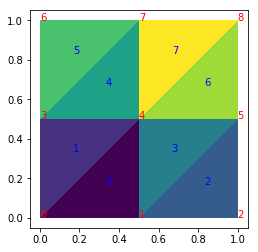

In [20]:
n = 2
mesh = UnitSquareMesh(n,n)

cell_f = CellFunction("size_t", mesh)
for cell in cells(mesh):
    cell_f[cell.index()] = cell.index()
    
p = df.plot(cell_f)
print p
ax = p.axes
for cell in cells(mesh):
    ax.text(cell.midpoint()[0], cell.midpoint()[1], '{}'.format(cell.index()), color='blue')
for v in vertices(mesh):
    ax.text(v.point()[0], v.point()[1], '{}'.format(v.index()), color='red')

Show dofs and cells of a discrete finite element space for CG and DG of different orders. 

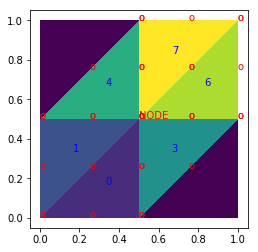

In [21]:
cg_space = FunctionSpace(mesh, 'CG', 3)
dg_space = FunctionSpace(mesh, 'DG', 2)

N = cg_space.dim()

cell_f = CellFunction("size_t", mesh)
cell_f.set_all(0)

texts = []

for v in vertices(cg_space.ufl_function_space().mesh()):
    if not v.index() == 4:
        continue
    patch = cells(v)
    texts.append((v.point()[0], v.point()[1], 'NODE', 'red'))
    for cell in patch:
        cell_f[cell.index()] = cell.index() + 1
        texts.append((cell.midpoint()[0], cell.midpoint()[1], '{}'.format(cell.index()), 'blue'))
        dg_dofs = dg_space.dofmap().cell_dofs(cell.index())
        
        dg_dof_vertices = (np.reshape(dg_space.tabulate_dof_coordinates(), (-1, 2))[dg_dofs])
        for node in dg_dof_vertices:
            texts.append((node[0], node[1], "o", 'red'))

p = plot(cell_f)
ax = p.axes

for lia in range(len(texts)):
    ax.text(texts[lia][0], texts[lia][1], texts[lia][2], color=texts[lia][3])

Test 3 different implementations for computing the integral 
$$ \int_D f g dx $$

- using dolfins assemble
- by usage of the local support property of the basis functions
- simply multipliying the coefficient vectors with the mass matrix


In [22]:
n = 50
mesh = UnitSquareMesh(n,n)
cg_space = FunctionSpace(mesh, 'CG', 3)
dg_space = FunctionSpace(mesh, 'DG', 2)
dg_dofs_coordinates = (np.reshape(dg_space.tabulate_dof_coordinates(), (-1, 2)))
dof_to_cell = [cell for cell in range(dg_space.mesh().num_cells()) for dof in dg_space.dofmap().cell_dofs(cell)]

assert (dg_dofs_coordinates.shape[0] == len(dof_to_cell))
f = Expression('1/(2-x[0]*x[1])', degree=3)
f = interpolate(f, dg_space)
g = Expression('3*x[0]*x[1] +2*x[1] - x[0]', degree=4)
g = interpolate(g, cg_space)

alpha = f.vector()[:]
T = np.zeros((len(alpha), int(comb(cg_space.ufl_element().degree() + 2, cg_space.ufl_element().degree()))))
for lia, dof in enumerate(dg_dofs_coordinates):
    cell = dof_to_cell[lia]
    cg_dofs = cg_space.dofmap().cell_dofs(cell)    # are the cg and dg cells ordered the same?
    T[lia, :] = g.vector()[cg_dofs]
    # print("dof {} at {} in DG cell {}".format(lia, dof, dof_to_cell[lia]))

# ####### assemble mass matrix
u = TestFunction(cg_space)
v = TrialFunction(dg_space)
M = v*u*dx(cg_space.mesh())
M = assemble(M).array()
# ####### 

dofmap = cg_space.dofmap()
# print T.shape
with TicToc(key="assemble", active=True, do_print=True):
    I = f * g * dx(cg_space.mesh())
    I = assemble(I)
    # print I
with TicToc(key="local support", active=True, do_print=True):
    I2 = np.sum([np.dot(T[lia, :], (M[dofmap.cell_dofs(dof_to_cell[lia]), lia] * alpha[lia])) for lia in range(T.shape[0])])
    # print I2
with TicToc(key="trial & test", active=True, do_print=True):
    I3 = np.dot(g.vector()[:], np.dot(M, f.vector()[:]))
    # print I3
assert_almost_equal(I3, I)
assert_almost_equal(I2, I)
print("Done")

assemble Elapsed time is 0.00496196746826 seconds  (overall 0.083026).
local support Elapsed time is 0.941243171692 seconds  (overall 424.566835).
trial & test Elapsed time is 0.413442850113 seconds  (overall 0.935643).
Done


Test the assumption
for $ f = \sum_{i=1}^{N_c} \alpha_i\phi_i$ and $g=\sum_{j=1}^{N_d}\beta_j\psi_j$
$$\int_D f (\nabla g)^T(\nabla g) f dx = \sum_{i=1}^{N_c}\sum_{i'=1}^{N_c} \sum_{j=1}^{N_d}\sum_{j'=1}^{N_d} \int_D \alpha_i \psi_i (\nabla (\beta_j \phi_j))^T(\nabla (\beta_{j'}) \phi_{j'}) \alpha_{i'} \psi_{i'} dx  = \sum_{i=1}^{N_c}\sum_{i'=1}^{N_c} \sum_{j=1}^{N_d}\sum_{j=1}^{N_d} (\alpha_i\alpha_{i'}\beta_j\beta_{j'}) \int_D \psi_i \psi_{i'}(\nabla \phi_j)^T (\nabla \phi_{j'}) dx (= \mathbf{\alpha}^T M \mathbf{\beta})$$

for $M = [m_{i,j, i', j'}] = \int_D \psi_j\psi_{j'}(\nabla \phi_i)^T(\nabla \phi_{i'}) dx $

This will not work due to the fact, that $M$ can not be assembled.
But, we know the following: 
- since $\psi_j \psi_{j'} = 0$ if $j$ and $j'$ do not belong to the same element and
- if $\psi_j$ and $\phi_i$ are defined on different elements, their product is $0$ as well
we can reduce the summation enormously by introducing the dofs per cell: $cell(i)$ contains all dofs of the corresponding space that share the same element with dof $i$

$$
\int_D f (\nabla g)^T(\nabla g) f dx = \sum_{i=1}^{N_c} \sum_{i'\in cell(i)} \sum_{j\in cell(i)} \sum_{j'\in cell(i)} \alpha_i \alpha_{i'} \beta_j \beta_{j'} \int_D \psi_i \psi_{i'}(\nabla \phi_j)^T (\nabla \phi_{j'}) dx
$$


In [2]:
n = 20

mesh = UnitSquareMesh(n,n)
cg_space = FunctionSpace(mesh, 'CG', 3)
dg_space = FunctionSpace(mesh, 'DG', 2)

f = Expression('1/(2-x[0]*x[1])', degree=3)
f = Expression('sin(10*pi*x[0])*cos(5*pi*x[1])*1/(2-x[0]*x[1])', degree=3)
f = interpolate(f, dg_space)
g = Expression('3*x[0]*x[1] +2*x[1] - x[0]', degree=4)
g = interpolate(g, cg_space)

print(dg_space.mesh().geometry().dim())


2


Standard implementation using the assemble function. Just as a reference, since this can not be done in the tensor case
$$ \int_D f\nabla g dx $$

In [31]:
u_1 = Function(cg_space)
u_2 = Function(cg_space)
v_1 = Function(dg_space)
v_2 = Function(dg_space)

alpha = f.vector()
beta = g.vector()

with TicToc(key="assemble", active=True, do_print=True):
    I = inner(f * nabla_grad(g), nabla_grad(g) * f) * dx(cg_space.mesh())
    I = assemble(I)
print("result = {}".format(I))
I_ref = I

assemble Elapsed time is 0.0137090682983 seconds  (overall 0.780104).
result = 1.31277113013


Test 1 for the idea of projecting the coefficient to a piecewise constant function
$$ f = \sum_{i=1}^{N_d} \alpha_i \psi_i \approx \sum_{i=1}^{N_d' << N_d} \tilde{\alpha}_i \tilde{\psi}_i$$
Then, we can integrate over every cell.

In [20]:
buf = Function(dg_space)
buf.vector()[:] = f.vector()[:]

refined_mesh = cg_space.mesh()
TicToc.clear()
for lia in range(6):
    
    DG0 = FunctionSpace(refined_mesh, 'DG', 0)
    dg0 = project(buf, DG0)
    dg1 = project(buf, DG0)
    with TicToc(key="assemble {}".format(lia+1), active=True, do_print=False):
        # ####### assemble stiffnes matrix
        u = TestFunction(cg_space)
        v = TrialFunction(cg_space)
        S = inner(nabla_grad(u), nabla_grad(v))*dg0*dg1*dx(cg_space.mesh())
        S = assemble(S).array()
        # ####### 
        I = np.dot(g.vector()[:], np.dot(S, g.vector()[:]))
    refined_mesh = refine(refined_mesh)
    print("result for DG0 space with {} dofs: {}    -  error={}".format(DG0.dim(), I, np.abs(I - I_ref)))
TicToc.sortedTimes()

# what happens if the coefficient is more oscilating?

Calling FFC just-in-time (JIT) compiler, this may take some time.
result for DG0 space with 800 dofs: 1.12626325009    -  error=0.186507880043
Calling FFC just-in-time (JIT) compiler, this may take some time.
result for DG0 space with 3200 dofs: 1.2793753637    -  error=0.0333957664262
result for DG0 space with 12800 dofs: 1.31688068112    -  error=0.00410955099089
result for DG0 space with 51200 dofs: 1.31689077304    -  error=0.00411964291399
result for DG0 space with 204800 dofs: 1.32002033505    -  error=0.00724920492133
result for DG0 space with 819200 dofs: 1.31859201774    -  error=0.00582088761476
o===================================o
|  Sorted tasks by amount of time   |
o===================================o
| assemble 1    0.882121  seconds |
| assemble 2    0.622090  seconds |
| assemble 6    0.379043  seconds |
| assemble 5    0.136614  seconds |
| assemble 4    0.059777  seconds |
| assemble 3    0.054635  seconds |
o===================================o


As an upper bound we can consider the Cauchy-Schwarz inequality:
$$
\int_D f f (\nabla g)^T(\nabla g) dx \leq \left(\int_D (ff)^2dx \int_D \left((\nabla g)^T(\nabla g)\right)^2 dx\right)^{\frac{1}{2}} 
$$
Hence, we can do this for every integral in the usual summation:
$$
\left( \sum_{i, i'=1}^{N_d}\sum_{j, j'=1}^{N_c} \alpha_i \alpha_{i'} \beta_j \beta_{j'} \int_D (\psi_i \psi_{i'})^2dx \int_D \left((\nabla \phi_j)^T(\nabla \phi_{j'})\right)^2 dx = (\alpha^T M \alpha)(\beta^T S \beta)\right)^{\frac{1}{2}}
$$


!!! This is not going to work since we can not assemble the squared functions in the integral !!!

In [13]:
    with TicToc(key="assemble {}".format(lia+1), active=True, do_print=False):
        alpha = np.array(f.vector()[:])**2
        beta = np.array(g.vector()[:])**2
        # ####### assemble mass matrix
        u = TestFunction(dg_space)
        v = TrialFunction(dg_space)
        M = (inner(u,v) * inner(u,v))*dx(dg_space.mesh())
        M = assemble(M).array()
        # ####### 
        # ####### assemble stiffnes matrix
        u = TestFunction(cg_space)
        v = TrialFunction(cg_space)
        S = inner(nabla_grad(u), nabla_grad(v))*dx(cg_space.mesh())
        S = assemble(S).array() ** 2
        # ####### 
        I = np.sqrt(np.dot(alpha, np.dot(M, alpha)) * np.dot(beta, np.dot(S, beta)))
        print("result = {}".format(I))

          Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to perform just-in-time compilation of form.
*** Reason:  ffc.jit failed with message:
Traceback (most recent call last):
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/dolfin/compilemodules/jit.py", line 142, in jit
    result = ffc.jit(ufl_object, parameters=p)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 204, in jit
    module = jit_build(ufl_object, module_name, parameters)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 120, in jit_build
    generate=jit_generate)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/dijitso/jit.py", line 160, in jit
    header, source, dependencies = generate(jitable, name, signature, params["generator"])
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/jitcompiler.py", line 66, in jit_generate
    prefix=module_name, parameters=parameters, jit=True)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/compiler.py", line 141, in compile_form
    prefix, parameters, jit)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/compiler.py", line 183, in compile_ufl_objects
    analysis = analyze_ufl_objects(ufl_objects, kind, parameters)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/analysis.py", line 94, in analyze_ufl_objects
    for form in forms)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/analysis.py", line 94, in <genexpr>
    for form in forms)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ffc/analysis.py", line 174, in _analyze_form
    do_apply_restrictions=True,
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/algorithms/compute_form_data.py", line 387, in compute_form_data
    check_form_arity(preprocessed_form, self.original_form.arguments())  # Currently testing how fast this is
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/algorithms/check_arities.py", line 152, in check_form_arity
    check_integrand_arity(itg.integrand(), arguments)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/algorithms/check_arities.py", line 145, in check_integrand_arity
    args = map_expr_dag(rules, expr, compress=False)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/corealg/map_dag.py", line 37, in map_expr_dag
    result, = map_expr_dags(function, [expression], compress=compress)
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/corealg/map_dag.py", line 86, in map_expr_dags
    r = handlers[v._ufl_typecode_](v, *[vcache[u] for u in v.ufl_operands])
  File "/home/marschall/anaconda2/envs/fenics/lib/python2.7/site-packages/ufl/algorithms/check_arities.py", line 57, in product
    raise ArityMismatch("Multiplying expressions with overlapping form argument number {0}, argument is {1}.".format(x.number(), x))
ArityMismatch: Multiplying expressions with overlapping form argument number 0, argument is v_0.
.
*** Where:   This error was encountered inside jit.py.
*** Process: 0
*** 
*** DOLFIN version: 2017.1.0
*** Git changeset:  368b07a8b3c7fa8acb10fa50a1ae933af9767081
*** -------------------------------------------------------------------------


In [4]:
import itertools as iter

DG = FunctionSpace(mesh, 'DG', 2)
_f = interpolate(f, DG)
_g = interpolate(g, DG)
DG_dofs = dict([(c.index(), DG.dofmap().cell_dofs(c.index())) for c in cells(mesh)])

# print(DG.dim())

#print(DG_dofs)

u, v = TrialFunction(DG), TestFunction(DG)

w1, w2 = Function(DG), Function(DG)

S, N = len(DG_dofs[0]), DG.dim()
idx = [i for i in iter.product(range(S), range(S))]
print DG_dofs[0]
I = 0
for i in idx:

    a1, a2 = np.zeros(N), np.zeros(N)

    for c in cells(mesh):

        cid = c.index()

        a1[DG_dofs[cid][i[0]]] = _f.vector()[DG_dofs[cid][i[0]]] 

        a2[DG_dofs[cid][i[1]]] = _f.vector()[DG_dofs[cid][i[1]]] 

    w1.vector()[:] = a1

    w2.vector()[:] = a2
    b = np.array(assemble(w1*w2*inner(nabla_grad(u),nabla_grad(v))*dx).array())
    I += np.dot(_g.vector()[:], np.dot(b, _g.vector()[:]))
    
print("result = {} and error to reference: {}".format(I, np.abs(I-I_ref)))

[1 0 2 3 4 5]


NameError: name 'I_ref' is not defined